## Using AI to discover more about company

<img src="https://r2cdn.perplexity.ai/pplx-full-logo-primary-dark%402x.png" style="height:64px;margin-right:32px"/>

* prompt: Help me understand how the company Olist makes money. What business model do they use to generate profit? Please provide the most reliable and up-to-date sources that specifically address this topic.

Olist's revenue generation is primarily based on a commission model where the company takes a percentage cut from sales transactions conducted through its platform. This commission typically ranges from around 20% to 30%, depending on the specific plan the seller chooses and the volume of sales.

The commission breakdown according to the common plans offered by Olist is as follows:

- The "Grow" plan, for sellers with monthly revenues up to R\$1 million, charges around 23% commission plus a fixed fee per item sold.
- The "Evolve" plan, aimed at sellers with monthly revenues between R\$1 million and R\$3 million, charges approximately 21% commission plus a fixed fee.
- Higher-tier plans for sellers with revenues above R\$3 million offer negotiated commissions, usually below 21%.

Olist also offers a SaaS platform with tools that integrate sales across multiple marketplaces and provide logistics, payment processing, and financial management. The fees encompass not only marketplace commissions but also services like order fulfillment and payment gateways, which contribute to the overall cost structure for sellers.

In summary, Olist’s business model involves:

- Taking 20-30% commission cuts on sales depending on the seller’s plan and volume.
- Providing a platform that consolidates sales channels, logistics, and financial tools.
- Offering subscription plans with various service levels and associated fees.

**Sources for your report:**

- "How Does Olist Company Work?" – Canvas Business Model, July 2025[^1]
- "Quanto Custa Vender na OLIST ?" – YouTube explanation, May 2024[^10]
- "Como Vender na OLIST - Marketplace OLIST do Zero" – YouTube tutorial, June 2024[^11]
- Olist official plans and pricing details (Olist.com)[^12]

These provide the clearest and most up-to-date descriptions of Olist’s commission structure and business model for sellers using their e-commerce platform. This information is current through 2025 and reflects the platform’s core revenue mechanisms.
<span style="display:none">[^2][^3][^4][^5][^6][^7][^8][^9]</span>

<div align="center">⁂</div>

[^1]: https://canvasbusinessmodel.com/blogs/how-it-works/olist-how-it-works

[^2]: https://metait.ai/cases/olist/

[^3]: https://olist.com/ecommerce/

[^4]: https://github.com/tolamoye/Olist-E-commerce-Data-Analysis

[^5]: https://www.studocu.vn/vn/document/truong-dai-hoc-kinh-te-thanh-pho-ho-chi-minh/business-analytics/project-outline/113858155

[^6]: https://olist.com

[^7]: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

[^8]: https://www.youtube.com/watch?v=grpZBiVqI4I

[^9]: https://canvasbusinessmodel.com/pt/collections/e-commerce/products/olist-pestle-analysis

[^10]: https://www.youtube.com/watch?v=FmPTAZdYCeo

[^11]: https://www.youtube.com/watch?v=tZkrgJuoCXI

[^12]: https://olist.com/planos/



In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from helpers.load_data import load_leads_with_deals
from helpers.macro_economic import get_selic_data

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

## Data Preparation

Revenue Forecasting with Time Series (ARIMA)

The idea is to use a time series model called ARIMA to predict revenue growth in the last available month.
The revenue variable will be expressed as a percentage of the company's monthly revenue.

To calculate this revenue, I will consider the value that the company starts receiving from the moment a lead is converted (closed). This way, I can build the month-by-month revenue time series.

The last month will be separated as test data, and the model will attempt to predict revenue growth based on patterns observed in previous months.
Finally, I will apply statistical methods to verify if the time series makes sense (i.e., if it is stationary, consistent, and suitable for the ARIMA model).

Macroeconomic Assumptions

Olist's lead conversion rate (companies that register and decide to sell online) tends to grow when:

- The economy is heated (there is more optimism and consumption)
- Credit is available (SMEs can finance working capital)
- Aggregate demand is growing (sales of goods and services increase)
- E-commerce is expanding (structural change in purchasing behavior)

The idea of using the basic interest rate (SELIC) is to understand how much the economy will experience heating or deceleration given the direction of monetary policy.

In [2]:
# Load and prepare data
df_leads_deals = load_leads_with_deals()
df_leads_deals = df_leads_deals[df_leads_deals["conversed_lead"]].copy()

df_leads_deals

,mql_id,first_contact_date,landing_page_id,origin,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,conversed_lead
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,True
12,a555fb36b9368110ede0f043dfc3b9a0,2018-04-04,2f08471dfb83baef522f952438a36f6e,referral,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0,True
14,327174d3648a2d047e8940d7d15204ca,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,True
39,f5fee8f7da74f4887f5bcae2bafb6dd6,2018-01-14,22c29808c4f815213303f8933030604c,paid_search,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0,True
67,ffe640179b554e295c167a2f6be528e0,2017-10-09,a0fbc0263cb98bdb0d72b9f9f283a172,unknown,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7978,df9a2abe2ad3f2d8758b675ac8331ecf,2018-03-28,a7982125ff7aa3b2054c6e44f9d28522,organic_search,bfcc27719640628da877db48b672b169,45749fb708130f78d0db07d8d80f030b,a8387c01a09e99ce014107505b92388c,2018-08-01 20:22:31,home_decor,offline,cat,NaN,NaN,NaN,reseller,NaN,0.0,True
7983,8723201570415eb23b4f095d8c20a27c,2018-05-18,b76ef37428e6799c421989521c0e5077,organic_search,4a82eab98441aeb64566e2776c1fb2b6,370c9f455f93a9a96cbe9bea48e70033,4b339f9567d060bcea4f5136b9f5949e,2018-09-27 18:58:41,construction_tools_house_garden,online_big,wolf,NaN,NaN,NaN,reseller,132.0,200000.0,True
7991,2e57665b8faf05c967a801eb5aedfa0a,2018-05-25,40dec9f3d5259a3d2dbcdab2114fae47,paid_search,55031883943971ca22db6894574cfe2c,370c9f455f93a9a96cbe9bea48e70033,a8387c01a09e99ce014107505b92388c,2018-06-06 20:15:26,computers,online_medium,wolf,NaN,NaN,NaN,reseller,NaN,0.0,True
7994,40955be51cc85c5a5a6cdd12b19e9f10,2018-02-04,88740e65d5d6b056e0cda098e1ea6313,social,c0e933c238e41f0cd459d6025ee9b364,068066e24f0c643eb1d089c7dd20cd73,d3d1e91a157ea7f90548eef82f1955e3,2018-03-06 15:52:23,pet,online_beginner,cat,NaN,NaN,NaN,reseller,NaN,0.0,True


In [3]:
# Load and prepare data
df_leads_deals = load_leads_with_deals()
df_leads_deals = df_leads_deals[df_leads_deals["conversed_lead"]].copy()

# Calculate trimmed mean to replace zero revenue values
# A trimmed mean is a mean calculated after removing a fraction of the smallest and largest values from the sample.
# It is used to reduce the influence of outliers in asymmetric distributions.
n = 10
s = df_leads_deals.loc[df_leads_deals["declared_monthly_revenue"] != 0, "declared_monthly_revenue"].dropna()
s_filtered = s[~s.isin(s.nsmallest(n)) & ~s.isin(s.nlargest(n))]
trimmed_mean = round(s_filtered.mean(), 2)
trimmed_mean

# Replace zeros with trimmed mean
df_leads_deals.loc[df_leads_deals["declared_monthly_revenue"] == 0, "declared_monthly_revenue"] = trimmed_mean


df_leads_deals["declared_monthly_revenue"].describe()

count    8.420000e+02
mean     1.314962e+05
std      1.742405e+06
min      6.000000e+00
25%      6.140000e+04
50%      6.140000e+04
75%      6.140000e+04
max      5.000000e+07
Name: declared_monthly_revenue, dtype: float64

In [4]:
def expand_weekly_revenue(df, end_date="2018-09-30", prorate_first_month=False, week_freq="W-MON"):
    """
    Expands each deal with declared monthly revenue (>0) into a weekly revenue series.
    Because the base revenue is monthly, each month is prorated to days and then
    aggregated into weeks (e.g., weeks starting on Monday).

    Parameters:
      - df: DataFrame with columns ['declared_monthly_revenue', 'won_date'].
            'won_date' must be a datetime-like column.
      - end_date: str or Timestamp; last day considered (e.g., '2018-12-31').
      - prorate_first_month: if True, the first month counts only from 'won_date' to month-end.
                             If False, the entire first month is counted.
      - week_freq: pandas weekly frequency alias. Default 'W-MON' (weeks start on Monday).
    """
    out = df.copy()

    # Keep only deals with positive revenue and valid won_date
    m = (out['declared_monthly_revenue'] > 0) & out['won_date'].notna()
    deals = out.loc[m].copy()

    # Normalize start and end to the BEGINNING of the month
    deals['start_month'] = deals['won_date'].dt.to_period('M').dt.to_timestamp()
    end_month = pd.to_datetime(end_date).to_period('M').to_timestamp()

    # Remove deals starting after the end period
    deals = deals.loc[deals['start_month'] <= end_month].copy()
    if deals.empty:
        return pd.DataFrame(columns=['week', 'total_revenue'])

    # Build list of months for each deal (MS = month start)
    deals['month_list'] = deals['start_month'].apply(lambda d: pd.date_range(d, end_month, freq='MS'))
    deals = deals.explode('month_list').rename(columns={'month_list': 'month'}).reset_index(drop=True)

    # Month boundaries
    deals['month_start'] = deals['month']
    deals['month_end'] = (deals['month'] + pd.offsets.MonthEnd(0)).dt.normalize()

    # Flag first month for each deal (based on original start_month)
    is_first = deals['month'] == deals['start_month']

    # Effective start for each monthly slice
    # - If not prorating first month -> use month_start
    # - If prorating -> for first month use won_date (normalized), else month_start
    won_date_norm = deals['won_date'].dt.normalize()
    deals['effective_start'] = np.where(
        prorate_first_month & is_first,
        won_date_norm,
        deals['month_start']
    )
    deals['effective_end'] = deals['month_end']

    deals = deals.loc[deals['effective_start'] <= deals['effective_end']].copy()

    # Days in each month and daily rate
    # Note: days_in_month is derived from the month_end day number
    deals['days_in_month'] = deals['month_end'].dt.day.astype(float)
    deals['daily_rate'] = deals['declared_monthly_revenue'] / deals['days_in_month']

    # Build per-day expansion within each monthly slice
    def _daterange(row):
        return pd.date_range(row['effective_start'], row['effective_end'], freq='D')

    deals['date_list'] = deals.apply(_daterange, axis=1)

    # If there are rows with zero-length ranges, drop them
    deals = deals[deals['date_list'].apply(len) > 0].copy()
    if deals.empty:
        return pd.DataFrame(columns=['week', 'total_revenue'])

    # Explode to daily level
    daily = deals[['date_list', 'daily_rate']].explode('date_list')
    daily = daily.rename(columns={'date_list': 'date'}).reset_index(drop=True)

    # Map each day to a week period (week starting on Monday by default)
    # 'week' will be the week start timestamp
    week_index = daily['date'].dt.to_period(week_freq).dt.start_time
    daily = daily.assign(week=week_index)

    # Aggregate to weekly portfolio
    weekly_portfolio = (
        daily.groupby('week', as_index=False)['daily_rate']
             .sum()
             .rename(columns={'daily_rate': 'total_revenue'})
             .sort_values('week')
             .reset_index(drop=True)
    )

    return weekly_portfolio

In [5]:
# Create weekly revenue series
df_leads_deals_revenue = df_leads_deals[["declared_monthly_revenue", "won_date"]].copy()
weekly_revenue = expand_weekly_revenue(df_leads_deals_revenue)[:-1] # remove last incomplete week

# Assuming Olist takes 20% commission
weekly_revenue["total_revenue"] = weekly_revenue["total_revenue"] * 0.2

# Split train/test (last month for testing)
split_date = "2018-06-01"
train = weekly_revenue[weekly_revenue["week"] < split_date].copy()
test = weekly_revenue[weekly_revenue["week"] >= split_date].copy()

print(f"Training period: {train['week'].min()} to {train['week'].max()}")
print(f"Test period: {test['week'].min()} to {test['week'].max()}")
print(f"Train size: {len(train)} weeks, Test size: {len(test)} weeks")

Training period: 2017-11-28 00:00:00 to 2018-05-29 00:00:00
Test period: 2018-06-05 00:00:00 to 2018-09-18 00:00:00
Train size: 27 weeks, Test size: 16 weeks


In [6]:
df_selic = get_selic_data("01/06/2017", "31/12/2018")
df_selic = df_selic.set_index('date')
df_selic = df_selic.shift(freq='2ME') # applying a 2-month lag, the average time it takes for the interest rate to affect economic outcomes

ts_selic = (df_selic
            .resample('W-TUE', label='left', closed='left')
            .first()
            .ffill()        
            .reset_index()
            .set_index("date"))

start = weekly_revenue["week"].min()
end = weekly_revenue["week"].max()

ts_selic = ts_selic.loc[start:end].copy()


start_tr = train["week"].min()
end_tr = train["week"].max()

selic_train = ts_selic.loc[start_tr:end_tr].copy()


start_te = test["week"].min()
end_te = test["week"].max()

selic_test = ts_selic.loc[start_te:end_te].copy()

## Univariate Statistical Analysis - Weekly Revenue


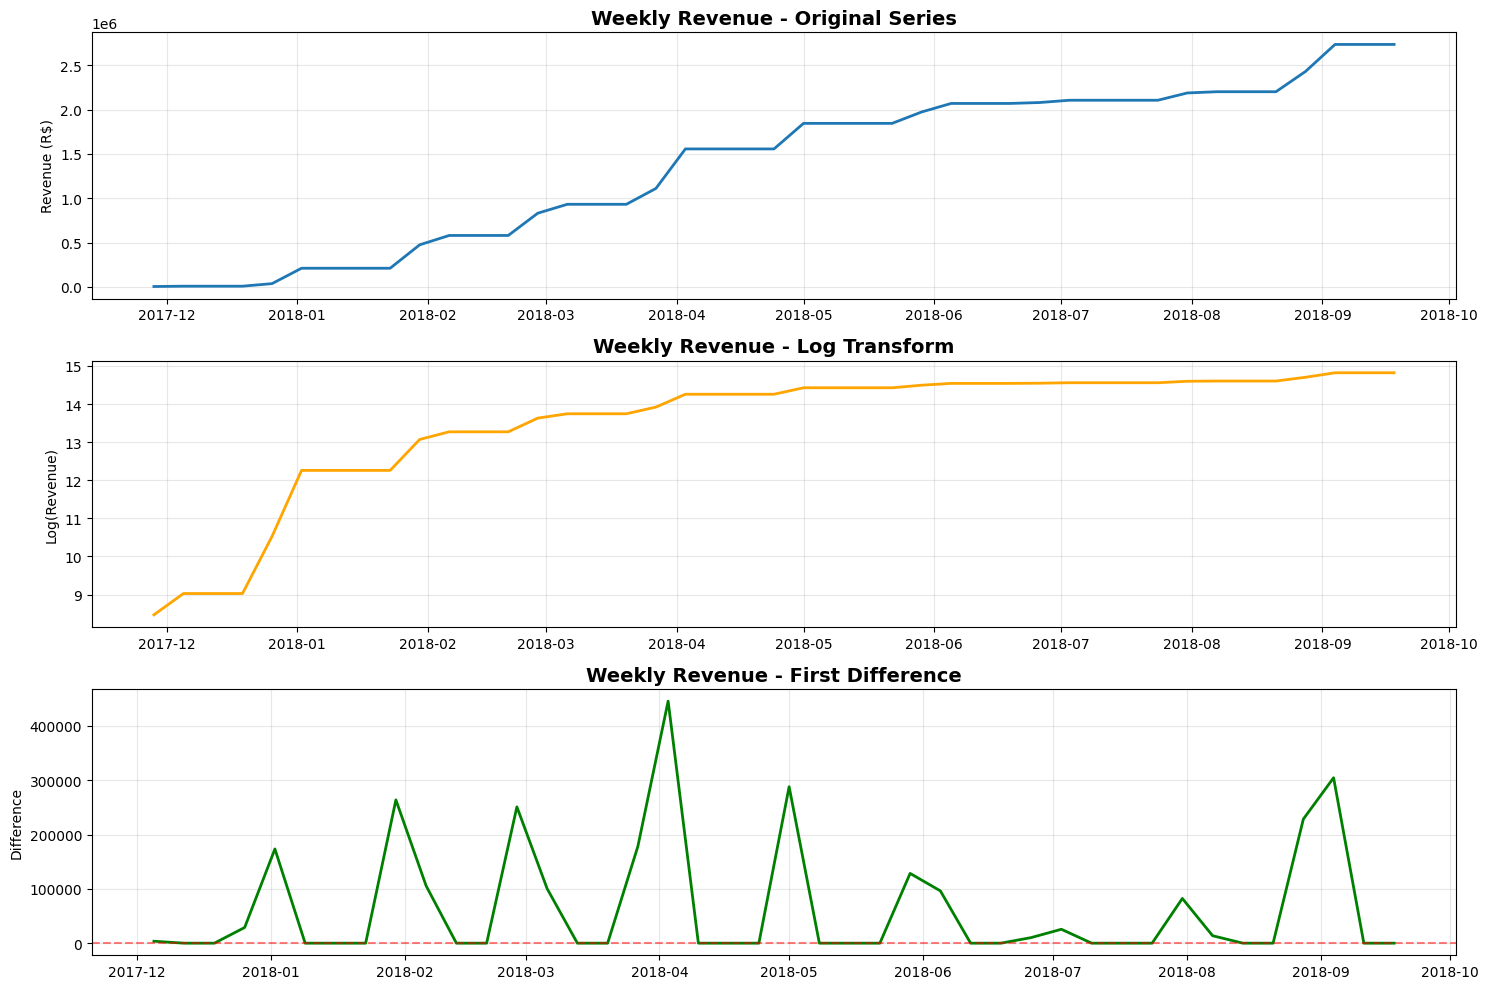


DESCRIPTIVE ANALYSIS - WEEKLY REVENUE

Period: 2017-11-28 00:00:00 to 2018-09-18 00:00:00
Total observations: 43

Original series statistics:
  Mean: R$ 1,385,054.19
  Median: R$ 1,555,876.00
  Std Dev: R$ 888,304.39
  Coef. of Variation: 64.13%
  Min: R$ 4,753.55
  Max: R$ 2,733,864.28


In [7]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

# Prepare time series
ts_revenue = weekly_revenue.set_index('week')['total_revenue']

# 1.1 Series visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Original series
axes[0].plot(ts_revenue.index, ts_revenue.values, linewidth=2)
axes[0].set_title('Weekly Revenue - Original Series', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Revenue (R$)')
axes[0].grid(alpha=0.3)

# Log of series (to stabilize variance)
ts_revenue_log = np.log(ts_revenue)
axes[1].plot(ts_revenue_log.index, ts_revenue_log.values, color='orange', linewidth=2)
axes[1].set_title('Weekly Revenue - Log Transform', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Log(Revenue)')
axes[1].grid(alpha=0.3)

# First difference
ts_revenue_diff = ts_revenue.diff().dropna()
axes[2].plot(ts_revenue_diff.index, ts_revenue_diff.values, color='green', linewidth=2)
axes[2].set_title('Weekly Revenue - First Difference', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Difference')
axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("DESCRIPTIVE ANALYSIS - WEEKLY REVENUE")
print("="*80)
print(f"\nPeriod: {ts_revenue.index.min()} to {ts_revenue.index.max()}")
print(f"Total observations: {len(ts_revenue)}")
print(f"\nOriginal series statistics:")
print(f"  Mean: R$ {ts_revenue.mean():,.2f}")
print(f"  Median: R$ {ts_revenue.median():,.2f}")
print(f"  Std Dev: R$ {ts_revenue.std():,.2f}")
print(f"  Coef. of Variation: {(ts_revenue.std()/ts_revenue.mean())*100:.2f}%")
print(f"  Min: R$ {ts_revenue.min():,.2f}")
print(f"  Max: R$ {ts_revenue.max():,.2f}")

In [8]:
# Stationarity Tests

def test_stationarity(timeseries, title=''):
    """
    Performs ADF and KPSS stationarity tests
    """
    print(f"\n{'='*80}")
    print(f"STATIONARITY TESTS - {title}")
    print('='*80)
    
    # Augmented Dickey-Fuller Test
    print('\n1. ADF Test (Augmented Dickey-Fuller):')
    print('   H0: Series has unit root (NON-stationary)')
    print('   H1: Series is stationary')
    adf_result = adfuller(timeseries, autolag='AIC')
    
    print(f'\n   ADF Statistic: {adf_result[0]:.6f}')
    print(f'   p-value: {adf_result[1]:.6f}')
    print(f'   Critical values:')
    for key, value in adf_result[4].items():
        print(f'      {key}: {value:.6f}')
    
    if adf_result[1] <= 0.05:
        print(f'\n   ✓ Result: Reject H0 (p={adf_result[1]:.4f}) → Series is STATIONARY')
    else:
        print(f'\n   ✗ Result: Fail to reject H0 (p={adf_result[1]:.4f}) → Series is NON-STATIONARY')
    
    # KPSS Test
    print('\n2. KPSS Test (Kwiatkowski-Phillips-Schmidt-Shin):')
    print('   H0: Series is stationary')
    print('   H1: Series has unit root (NON-stationary)')
    kpss_result = kpss(timeseries, regression='ct', nlags='auto')
    
    print(f'\n   KPSS Statistic: {kpss_result[0]:.6f}')
    print(f'   p-value: {kpss_result[1]:.6f}')
    print(f'   Critical values:')
    for key, value in kpss_result[3].items():
        print(f'      {key}: {value:.6f}')
    
    if kpss_result[1] >= 0.05:
        print(f'\n   ✓ Result: Fail to reject H0 (p={kpss_result[1]:.4f}) → Series is STATIONARY')
    else:
        print(f'\n   ✗ Result: Reject H0 (p={kpss_result[1]:.4f}) → Series is NON-STATIONARY')
    
    return adf_result, kpss_result

# Test original series
test_stationarity(ts_revenue, 'Original Revenue')

# Test log series
test_stationarity(ts_revenue_log, 'Revenue Log Transform')

# Test first difference
test_stationarity(ts_revenue_diff, 'Revenue - First Difference')


STATIONARITY TESTS - Original Revenue

1. ADF Test (Augmented Dickey-Fuller):
   H0: Series has unit root (NON-stationary)
   H1: Series is stationary

   ADF Statistic: -0.916501
   p-value: 0.782490
   Critical values:
      1%: -3.615509
      5%: -2.941262
      10%: -2.609200

   ✗ Result: Fail to reject H0 (p=0.7825) → Series is NON-STATIONARY

2. KPSS Test (Kwiatkowski-Phillips-Schmidt-Shin):
   H0: Series is stationary
   H1: Series has unit root (NON-stationary)

   KPSS Statistic: 0.174569
   p-value: 0.026192
   Critical values:
      10%: 0.119000
      5%: 0.146000
      2.5%: 0.176000
      1%: 0.216000

   ✗ Result: Reject H0 (p=0.0262) → Series is NON-STATIONARY

STATIONARITY TESTS - Revenue Log Transform

1. ADF Test (Augmented Dickey-Fuller):
   H0: Series has unit root (NON-stationary)
   H1: Series is stationary

   ADF Statistic: -3.553521
   p-value: 0.006714
   Critical values:
      1%: -3.653520
      5%: -2.957219
      10%: -2.617588

   ✓ Result: Reject H0 

/var/folders/ms/h0brtvw14llfsgg43rnzl3780000gn/T/ipykernel_81956/1343453014.py:32: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries, regression='ct', nlags='auto')


((np.float64(-2.0531748379615267),
  np.float64(0.26375500393030404),
  3,
  38,
  {'1%': np.float64(-3.6155091011809297),
   '5%': np.float64(-2.941262357486514),
   '10%': np.float64(-2.6091995013850418)},
  np.float64(803.3567333038084)),
 (np.float64(0.1048208666204036),
  np.float64(0.1),
  8,
  {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}))

## Bivariate Statistical Analysis - SELIC


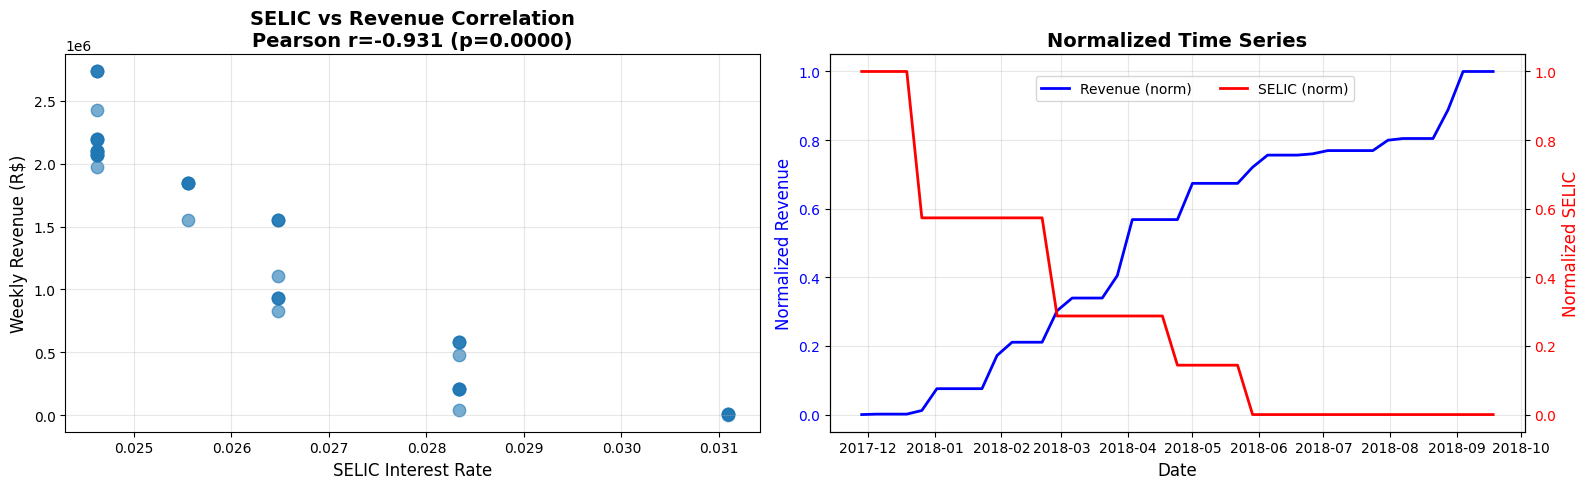


CORRELATION ANALYSIS - REVENUE vs SELIC

Pearson Correlation: -0.9307 (p-value: 0.0000)
Spearman Correlation: -0.9603 (p-value: 0.0000)

Interpretation: Strong and negative correlation
Significance: Significant at 5% level


In [9]:
# Correlation between SELIC and Revenue
from scipy.stats import pearsonr, spearmanr

# Align the series
df_combined = pd.concat([ts_revenue.squeeze().rename('revenue'), ts_selic.squeeze().rename('selic'), ], axis=1)

# Calculate correlations
pearson_corr, pearson_pval = pearsonr(df_combined['revenue'], df_combined['selic'])
spearman_corr, spearman_pval = spearmanr(df_combined['revenue'], df_combined['selic'])

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scatter plot
axes[0].scatter(df_combined['selic'], df_combined['revenue'], alpha=0.6, s=80)
axes[0].set_xlabel('SELIC Interest Rate', fontsize=12)
axes[0].set_ylabel('Weekly Revenue (R$)', fontsize=12)
axes[0].set_title(f'SELIC vs Revenue Correlation\nPearson r={pearson_corr:.3f} (p={pearson_pval:.4f})', 
                  fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Overlaid time series (normalized scales)
ax1 = axes[1]
ax2 = ax1.twinx()

revenue_norm = (ts_revenue - ts_revenue.min()) / (ts_revenue.max() - ts_revenue.min())
selic_norm = (ts_selic - ts_selic.min()) / (ts_selic.max() - ts_selic.min())

ax1.plot(ts_revenue.index, revenue_norm, 'b-', linewidth=2, label='Revenue (norm)')
ax2.plot(ts_selic.index, selic_norm, 'r-', linewidth=2, label='SELIC (norm)')

ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Normalized Revenue', color='b', fontsize=12)
ax2.set_ylabel('Normalized SELIC', color='r', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')
ax1.set_title('Normalized Time Series', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

fig.legend(loc='upper center', bbox_to_anchor=(0.75, 0.85), ncol=2)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("CORRELATION ANALYSIS - REVENUE vs SELIC")
print("="*80)
print(f"\nPearson Correlation: {pearson_corr:.4f} (p-value: {pearson_pval:.4f})")
print(f"Spearman Correlation: {spearman_corr:.4f} (p-value: {spearman_pval:.4f})")

if abs(pearson_corr) < 0.3:
    strength = "weak"
elif abs(pearson_corr) < 0.7:
    strength = "moderate"
else:
    strength = "strong"
    
direction = "negative" if pearson_corr < 0 else "positive"
print(f"\nInterpretation: {strength.capitalize()} and {direction} correlation")
print(f"Significance: {'Significant' if pearson_pval < 0.05 else 'Not significant'} at 5% level")

## Model 1: ARIMA (Univariate)

Simple ARIMA model using only historical revenue data.

In [10]:
# Prepare time series
ts_train = train.set_index('week')['total_revenue']
ts_test = test.set_index('week')['total_revenue']

# Fit ARIMA model with automatic order selection
arima_model = ARIMA(ts_train, order=(1, 1, 0))
arima_fit = arima_model.fit()

print("\n" + "="*80)
print("ARIMA MODEL SUMMARY")
print("="*80)
print(arima_fit.summary())

/Users/viniciusalcantara/Documents/GitHub/growth-intelligence-datascience-case-cobre/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/Users/viniciusalcantara/Documents/GitHub/growth-intelligence-datascience-case-cobre/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/Users/viniciusalcantara/Documents/GitHub/growth-intelligence-datascience-case-cobre/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)



ARIMA MODEL SUMMARY
                               SARIMAX Results                                
Dep. Variable:          total_revenue   No. Observations:                   27
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -344.126
Date:                Mon, 03 Nov 2025   AIC                            692.252
Time:                        00:12:29   BIC                            694.768
Sample:                    11-28-2017   HQIC                           692.976
                         - 05-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2761      0.204      1.356      0.175      -0.123       0.675
sigma2      1.908e+10   6.24e-12   3.06e+21      0.000    1.91e+10    1.91e+10
Ljung-Box (L1) (Q):            

In [11]:
# Make predictions
arima_forecast = arima_fit.forecast(steps=len(ts_test))
arima_forecast_with_ci = arima_fit.get_forecast(steps=len(ts_test))
arima_ci = arima_forecast_with_ci.conf_int(alpha=0.05)  # 95% confidence interval

# Calculate metrics
arima_mae = mean_absolute_error(ts_test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(ts_test, arima_forecast))
arima_mape = mean_absolute_percentage_error(ts_test, arima_forecast) * 100

print("\n" + "="*80)
print("ARIMA MODEL PERFORMANCE")
print("="*80)
print(f"MAE:  R$ {arima_mae:,.2f}")
print(f"RMSE: R$ {arima_rmse:,.2f}")
print(f"MAPE: {arima_mape:.2f}%")
print(f"AIC:  {arima_fit.aic:.2f}")
print(f"BIC:  {arima_fit.bic:.2f}")


ARIMA MODEL PERFORMANCE
MAE:  R$ 237,483.63
RMSE: R$ 340,274.21
MAPE: 9.58%
AIC:  692.25
BIC:  694.77


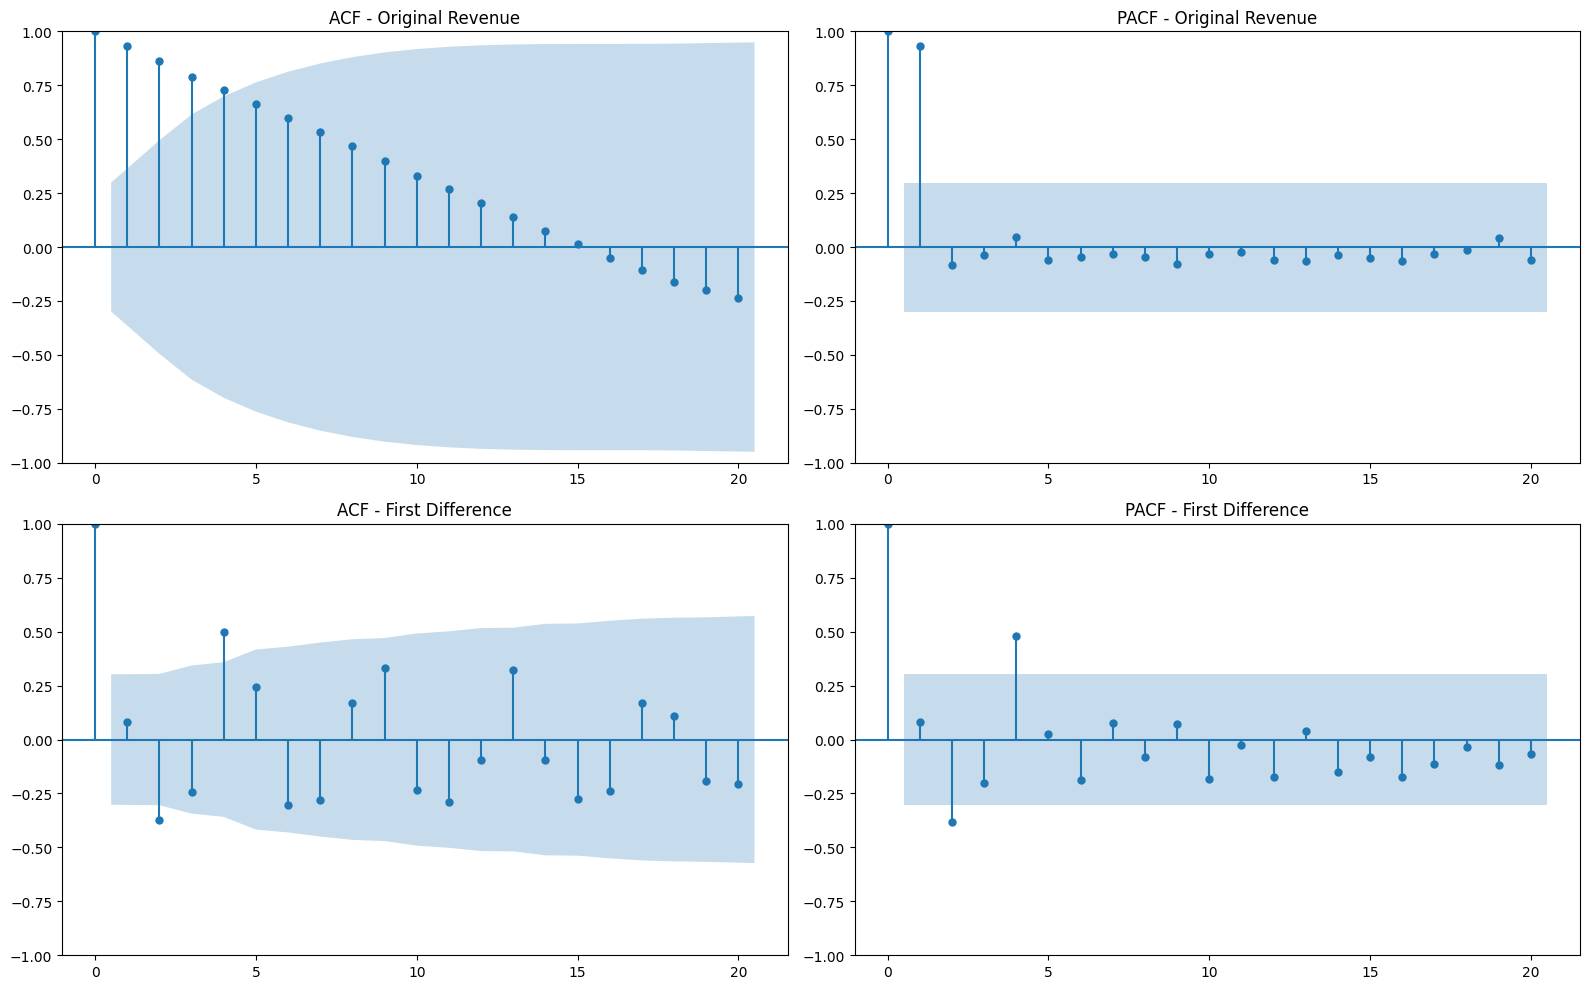

In [12]:
# ACF and PACF - Model order identification

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ACF and PACF - Original Series
plot_acf(ts_revenue, lags=20, ax=axes[0, 0], title='ACF - Original Revenue')
plot_pacf(ts_revenue, lags=20, ax=axes[0, 1], title='PACF - Original Revenue', method='ywm')

# ACF and PACF - First Difference
plot_acf(ts_revenue_diff, lags=20, ax=axes[1, 0], title='ACF - First Difference')
plot_pacf(ts_revenue_diff, lags=20, ax=axes[1, 1], title='PACF - First Difference', method='ywm')

plt.tight_layout()
plt.show()

# To identify ARIMA(p,d,q) parameters:
#   - p (AR): Autoregressive order → observe PACF (sharp cutoffs)
#   - d: Differencing order → number of differences until stationarity
#   - q (MA): Moving average order → observe ACF (sharp cutoffs)

# Common patterns:
#   - ACF decaying slowly + PACF with cutoff → AR(p) model
#   - ACF with cutoff + PACF decaying → MA(q) model
#   - Both decaying exponentially → ARMA(p,q) model

## Model 2: SARIMAX (with SELIC)

In [13]:
# Fit SARIMAX model
print("Fitting SARIMAX model with SELIC...")
sarimax_model = SARIMAX(ts_train, exog=selic_train, order=(1, 0, 0))
sarimax_fit = sarimax_model.fit(disp=False)

print("\n" + "="*80)
print("SARIMAX MODEL SUMMARY")
print("="*80)
print(sarimax_fit.summary())

Fitting SARIMAX model with SELIC...

SARIMAX MODEL SUMMARY
                               SARIMAX Results                                
Dep. Variable:          total_revenue   No. Observations:                   27
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -361.567
Date:                Mon, 03 Nov 2025   AIC                            729.135
Time:                        00:12:29   BIC                            733.022
Sample:                    11-28-2017   HQIC                           730.291
                         - 05-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
selic       2.987e+07   3.94e-11   7.58e+17      0.000    2.99e+07    2.99e+07
ar.L1          0.9896      0.048     20.803      0.000       0.896      

/Users/viniciusalcantara/Documents/GitHub/growth-intelligence-datascience-case-cobre/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/Users/viniciusalcantara/Documents/GitHub/growth-intelligence-datascience-case-cobre/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)


In [14]:
# Make predictions
sarimax_forecast = sarimax_fit.forecast(steps=len(ts_test), exog=selic_test)
sarimax_forecast_with_ci = sarimax_fit.get_forecast(steps=len(ts_test), exog=selic_test)
sarimax_ci = sarimax_forecast_with_ci.conf_int(alpha=0.05)  # 95% confidence interval

# Calculate metrics
sarimax_mae = mean_absolute_error(ts_test, sarimax_forecast)
sarimax_rmse = np.sqrt(mean_squared_error(ts_test, sarimax_forecast))
sarimax_mape = mean_absolute_percentage_error(ts_test, sarimax_forecast) * 100

print("\n" + "="*80)
print("SARIMAX MODEL PERFORMANCE")
print("="*80)
print(f"MAE:  R$ {sarimax_mae:,.2f}")
print(f"RMSE: R$ {sarimax_rmse:,.2f}")
print(f"MAPE: {sarimax_mape:.2f}%")
print(f"AIC:  {sarimax_fit.aic:.2f}")
print(f"BIC:  {sarimax_fit.bic:.2f}")


SARIMAX MODEL PERFORMANCE
MAE:  R$ 389,455.16
RMSE: R$ 486,778.75
MAPE: 16.18%
AIC:  729.13
BIC:  733.02


In [15]:
# Create comparison table
comparison = pd.DataFrame({
    'Model': ['ARIMA(1,1,1)', 'SARIMAX(1,1,1) + SELIC'],
    'MAE (R$)': [arima_mae, sarimax_mae],
    'RMSE (R$)': [arima_rmse, sarimax_rmse],
    'MAPE (%)': [arima_mape, sarimax_mape],
    'AIC': [arima_fit.aic, sarimax_fit.aic],
    'BIC': [arima_fit.bic, sarimax_fit.bic]
})

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison.to_string(index=False))

# Determine best model
if sarimax_mae < arima_mae:
    best_model_name = "SARIMAX"
    best_model = sarimax_fit
    best_forecast = sarimax_forecast
    best_ci = sarimax_ci
    improvement = ((arima_mae - sarimax_mae) / arima_mae) * 100
    print(f"\n✓ SARIMAX is better by {improvement:.2f}% (MAE reduction)")
else:
    best_model_name = "ARIMA"
    best_model = arima_fit
    best_forecast = arima_forecast
    best_ci = arima_ci
    improvement = ((sarimax_mae - arima_mae) / sarimax_mae) * 100
    print(f"\n✓ ARIMA is better by {improvement:.2f}% (MAE reduction)")


MODEL COMPARISON
                 Model      MAE (R$)     RMSE (R$)  MAPE (%)        AIC        BIC
          ARIMA(1,1,1) 237483.628391 340274.212310  9.583303 692.251729 694.767922
SARIMAX(1,1,1) + SELIC 389455.159058 486778.753386 16.177470 729.134853 733.022364

✓ ARIMA is better by 39.02% (MAE reduction)


## Visualization and Final Forecast

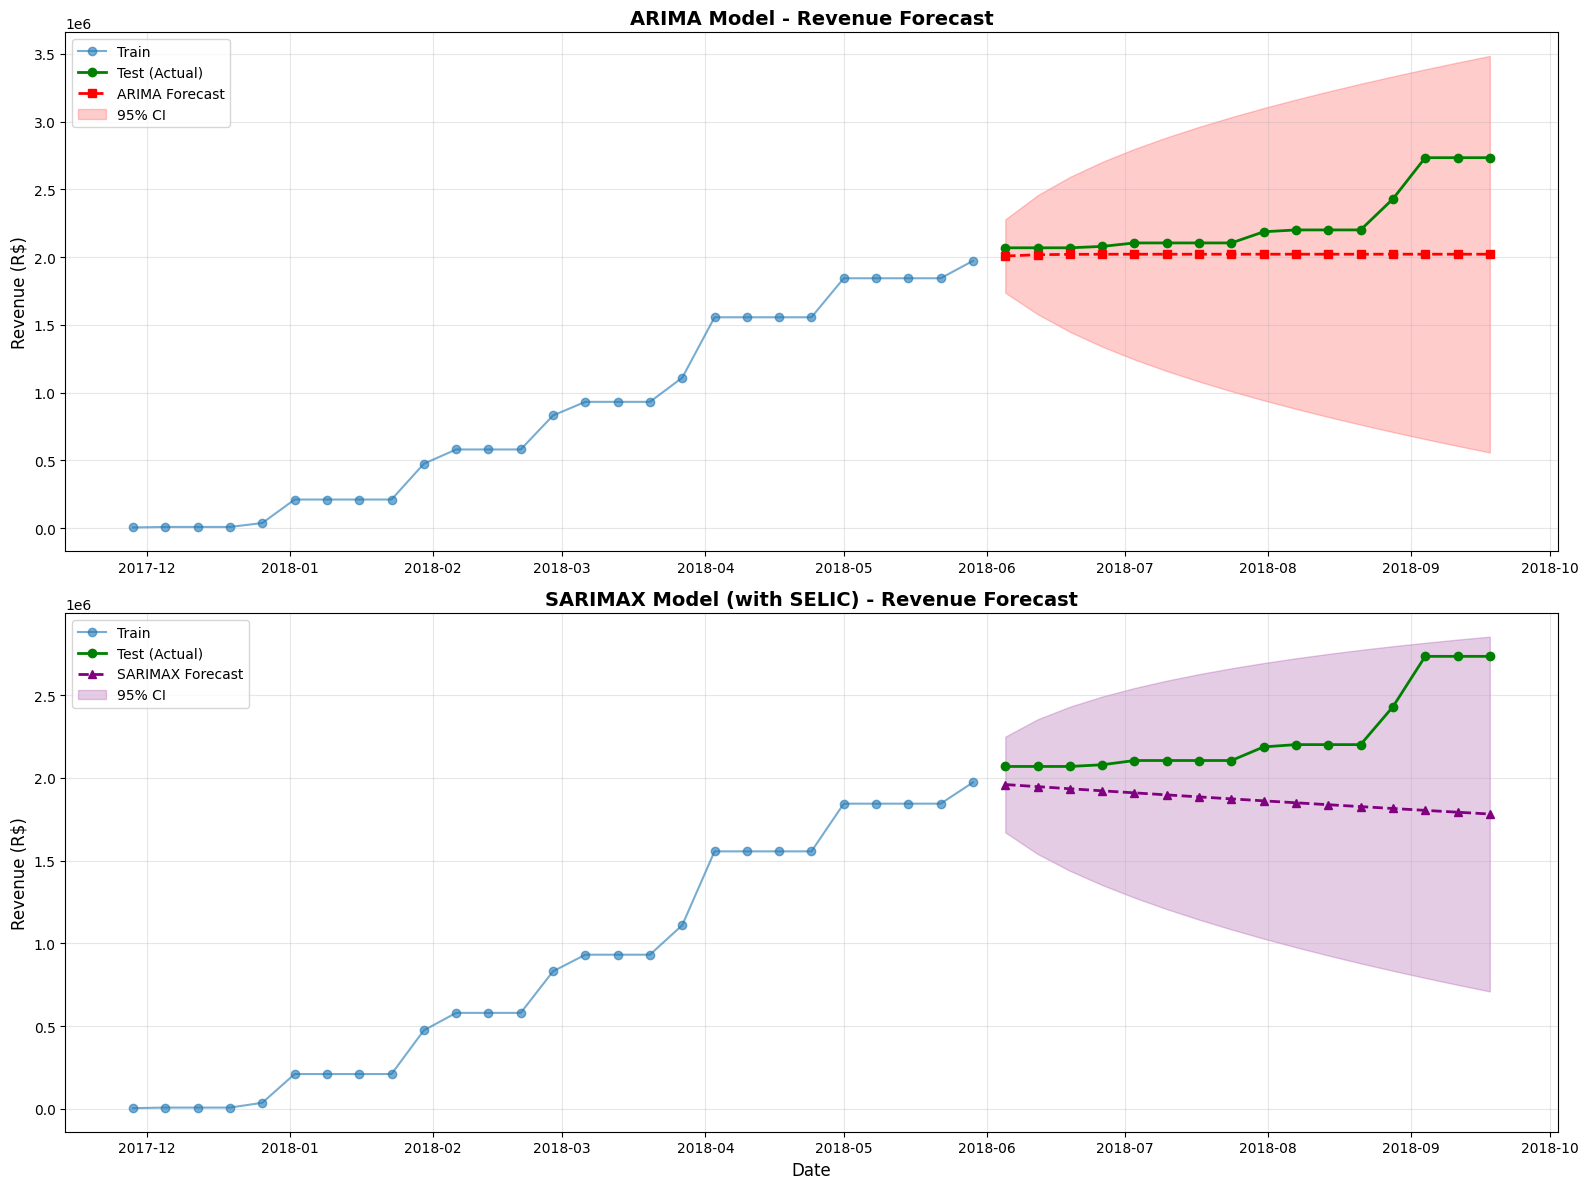

In [16]:
# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# ARIMA
axes[0].plot(train['week'], train['total_revenue'], 'o-', label='Train', alpha=0.6)
axes[0].plot(test['week'], test['total_revenue'], 'o-', label='Test (Actual)', color='green', linewidth=2)
axes[0].plot(test['week'], arima_forecast.values, 's--', label='ARIMA Forecast', color='red', linewidth=2)
axes[0].fill_between(test['week'], 
                      arima_ci.iloc[:, 0], 
                      arima_ci.iloc[:, 1], 
                      alpha=0.2, color='red', label='95% CI')
axes[0].set_title('ARIMA Model - Revenue Forecast', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Revenue (R$)', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.3)

# SARIMAX
axes[1].plot(train['week'], train['total_revenue'], 'o-', label='Train', alpha=0.6)
axes[1].plot(test['week'], test['total_revenue'], 'o-', label='Test (Actual)', color='green', linewidth=2)
axes[1].plot(test['week'], sarimax_forecast.values, '^--', label='SARIMAX Forecast', color='purple', linewidth=2)
axes[1].fill_between(test['week'], 
                      sarimax_ci.iloc[:, 0], 
                      sarimax_ci.iloc[:, 1], 
                      alpha=0.2, color='purple', label='95% CI')
axes[1].set_title('SARIMAX Model (with SELIC) - Revenue Forecast', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Revenue (R$)', fontsize=12)
axes[1].legend(loc='upper left')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()